<a href="https://colab.research.google.com/github/Rishabh-Shukla-15/Speech-Emotion-Recognition/blob/main/serCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install librosa kaggle --quiet

In [9]:
from google.colab import files

In [10]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [11]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
!kaggle datasets download -d ejlok1/cremad
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess
!kaggle datasets download -d ejlok1/surrey-audiovisual-expressed-emotion-savee

Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 88% 379M/429M [00:01<00:00, 323MB/s]
100% 429M/429M [00:01<00:00, 259MB/s]
Dataset URL: https://www.kaggle.com/datasets/ejlok1/cremad
License(s): ODC Attribution License (ODC-By)
 97% 438M/451M [00:00<00:00, 413MB/s]
100% 451M/451M [00:00<00:00, 491MB/s]
Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 92% 392M/428M [00:02<00:00, 118MB/s]
100% 428M/428M [00:02<00:00, 175MB/s]
Dataset URL: https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee
License(s): copyright-authors
 85% 91.0M/107M [00:00<00:00, 952MB/s]
100% 107M/107M [00:00<00:00, 835MB/s] 


In [12]:
!unzip -q ravdess-emotional-speech-audio.zip
!unzip -q cremad.zip
!unzip -q toronto-emotional-speech-set-tess.zip
!unzip -q surrey-audiovisual-expressed-emotion-savee.zip


In [13]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

In [14]:
Ravdess = "audio_speech_actors_01-24/"
Crema = "AudioWAV/"
Tess = "TESS Toronto emotional speech set data/"
Savee = "ALL/"

In [15]:
ravdess_emotion = []
ravdess_path = []

for actor in os.listdir(Ravdess):
    actor_path = os.path.join(Ravdess, actor)

    if os.path.isdir(actor_path):
        for file in os.listdir(actor_path):
            part = file.split('.')[0].split('-')
            emotion = int(part[2])

            ravdess_emotion.append(emotion)
            ravdess_path.append(os.path.join(actor_path, file))

Ravdess_df = pd.DataFrame({
    "Emotions": ravdess_emotion,
    "Path": ravdess_path
})

Ravdess_df.Emotions.replace({
    1:'neutral', 2:'calm', 3:'happy', 4:'sad',
    5:'angry', 6:'fear', 7:'disgust', 8:'surprise'
}, inplace=True)

Ravdess_df.head()

/tmp/ipython-input-400/247710205.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Ravdess_df.Emotions.replace({


Emotions                                               Path
0       sad  audio_speech_actors_01-24/Actor_02/03-01-04-02...
1     angry  audio_speech_actors_01-24/Actor_02/03-01-05-02...
2      fear  audio_speech_actors_01-24/Actor_02/03-01-06-02...
3       sad  audio_speech_actors_01-24/Actor_02/03-01-04-02...
4  surprise  audio_speech_actors_01-24/Actor_02/03-01-08-02...

In [16]:
crema_emotion = []
crema_path = []

for file in os.listdir(Crema):
    crema_path.append(os.path.join(Crema, file))
    part = file.split('_')

    if part[2] == 'SAD':
        crema_emotion.append('sad')
    elif part[2] == 'ANG':
        crema_emotion.append('angry')
    elif part[2] == 'DIS':
        crema_emotion.append('disgust')
    elif part[2] == 'FEA':
        crema_emotion.append('fear')
    elif part[2] == 'HAP':
        crema_emotion.append('happy')
    elif part[2] == 'NEU':
        crema_emotion.append('neutral')
    else:
        crema_emotion.append('surprise')

Crema_df = pd.DataFrame({
    "Emotions": crema_emotion,
    "Path": crema_path
})

Crema_df.head()

Emotions                          Path
0    happy  AudioWAV/1011_TSI_HAP_XX.wav
1  disgust  AudioWAV/1058_WSI_DIS_XX.wav
2    angry  AudioWAV/1019_ITS_ANG_XX.wav
3  neutral  AudioWAV/1019_IOM_NEU_XX.wav
4    happy  AudioWAV/1012_ITH_HAP_XX.wav

In [17]:
tess_emotion = []
tess_path = []

for folder in os.listdir(Tess):
    folder_path = os.path.join(Tess, folder)

    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            part = file.split('.')[0].split('_')[2]

            if part == 'ps':
                tess_emotion.append('surprise')
            else:
                tess_emotion.append(part)

            tess_path.append(os.path.join(folder_path, file))

Tess_df = pd.DataFrame({
    "Emotions": tess_emotion,
    "Path": tess_path
})

Tess_df.head()

Emotions                                               Path
0  neutral  TESS Toronto emotional speech set data/OAF_neu...
1  neutral  TESS Toronto emotional speech set data/OAF_neu...
2  neutral  TESS Toronto emotional speech set data/OAF_neu...
3  neutral  TESS Toronto emotional speech set data/OAF_neu...
4  neutral  TESS Toronto emotional speech set data/OAF_neu...

In [18]:
savee_emotion = []
savee_path = []

for file in os.listdir(Savee):
    savee_path.append(os.path.join(Savee, file))

    part = file.split('_')[1]
    ele = part[:-6]

    if ele == 'a':
        savee_emotion.append('angry')
    elif ele == 'd':
        savee_emotion.append('disgust')
    elif ele == 'f':
        savee_emotion.append('fear')
    elif ele == 'h':
        savee_emotion.append('happy')
    elif ele == 'n':
        savee_emotion.append('neutral')
    elif ele == 'sa':
        savee_emotion.append('sad')
    else:
        savee_emotion.append('surprise')

Savee_df = pd.DataFrame({
    "Emotions": savee_emotion,
    "Path": savee_path
})

Savee_df.head()

Emotions             Path
0      fear   ALL/DC_f02.wav
1     angry   ALL/JE_a03.wav
2       sad  ALL/JK_sa02.wav
3  surprise  ALL/JK_su09.wav
4       sad  ALL/JK_sa11.wav

In [19]:
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis=0)
data_path.reset_index(drop=True, inplace=True)

data_path.head()

Emotions                                               Path
0       sad  audio_speech_actors_01-24/Actor_02/03-01-04-02...
1     angry  audio_speech_actors_01-24/Actor_02/03-01-05-02...
2      fear  audio_speech_actors_01-24/Actor_02/03-01-06-02...
3       sad  audio_speech_actors_01-24/Actor_02/03-01-04-02...
4  surprise  audio_speech_actors_01-24/Actor_02/03-01-08-02...

In [20]:
print("Total samples:", len(data_path))
print(data_path['Emotions'].value_counts())

Total samples: 12162
Emotions
sad         1923
angry       1923
fear        1923
disgust     1923
happy       1923
neutral     1703
surprise     652
calm         192
Name: count, dtype: int64


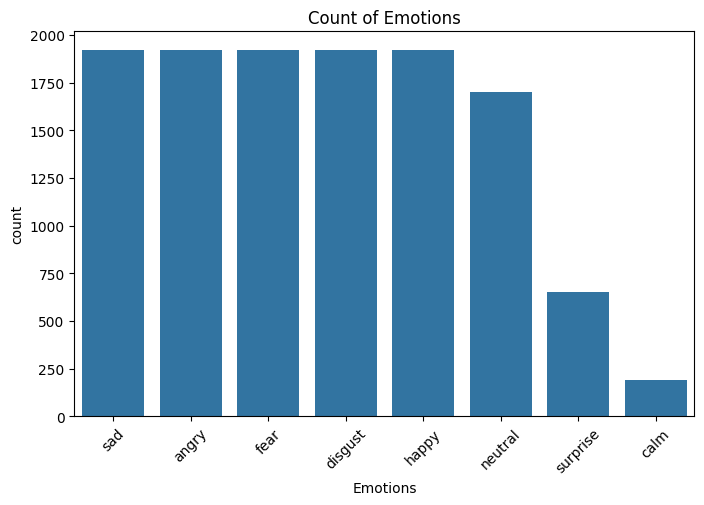

In [21]:
plt.figure(figsize=(8,5))
sns.countplot(x=data_path['Emotions'], order=data_path['Emotions'].value_counts().index)
plt.title("Count of Emotions")
plt.xticks(rotation=45)
plt.show()

In [22]:
def create_waveplot(data, sr, emotion):
    plt.figure(figsize=(10,3))
    plt.title(f'Waveplot - {emotion}')
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, emotion):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(np.abs(X))
    plt.figure(figsize=(10,4))
    plt.title(f'Spectrogram - {emotion}')
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.show()

In [23]:
from IPython.display import Audio, display

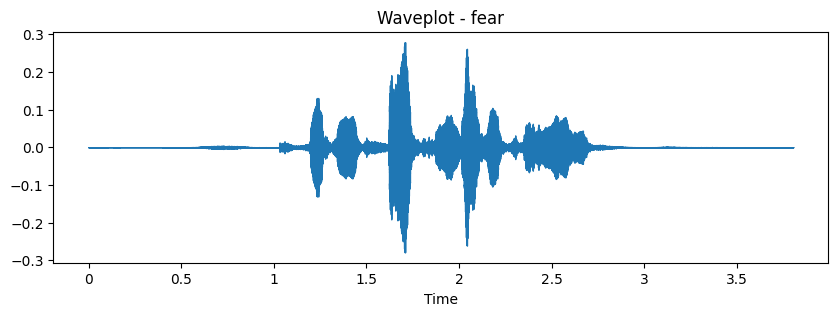

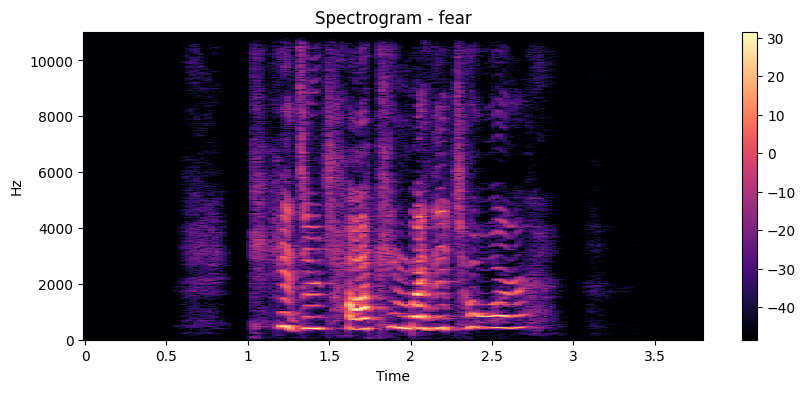

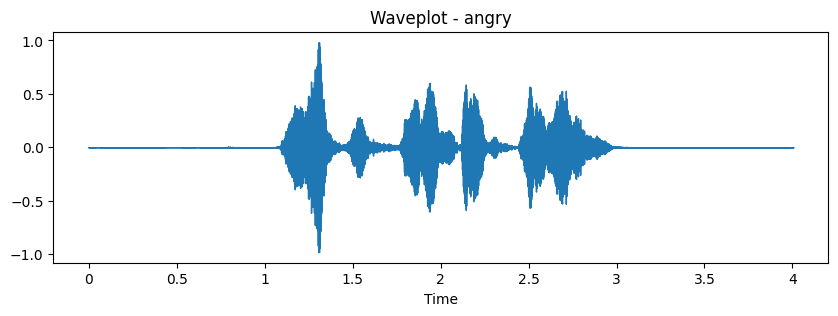

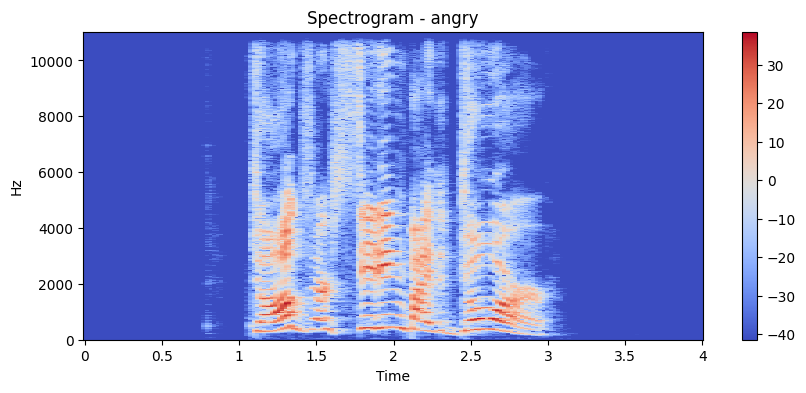

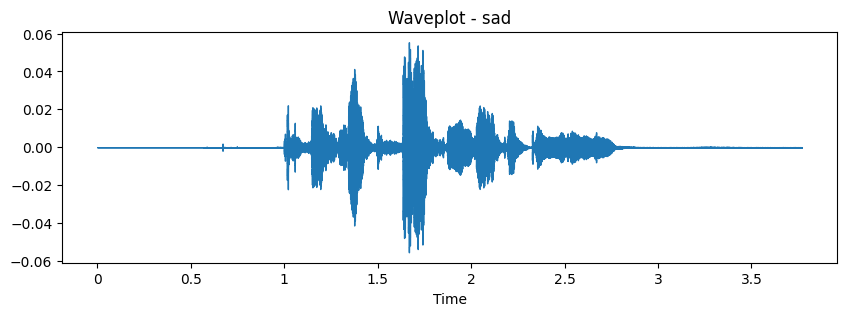

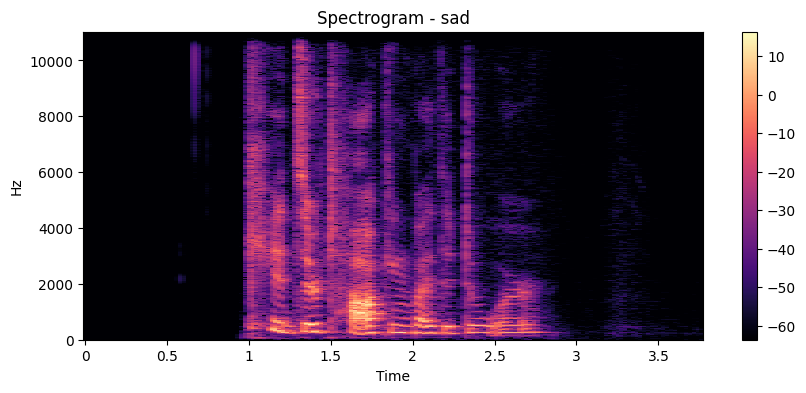

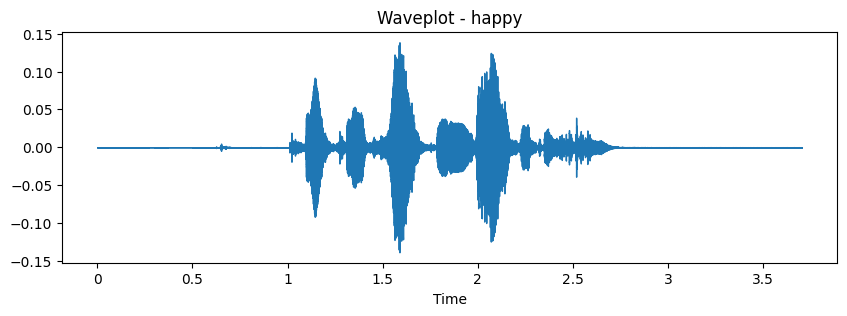

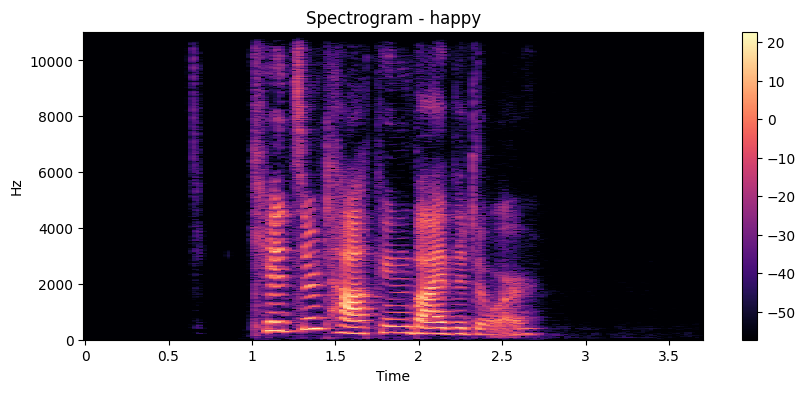

In [24]:
for emotion in ['fear','angry','sad','happy']:
    path = np.array(data_path.Path[data_path.Emotions==emotion])[0]
    data, sr = librosa.load(path)

    create_waveplot(data, sr, emotion)
    create_spectrogram(data, sr, emotion)
    display(Audio(path))

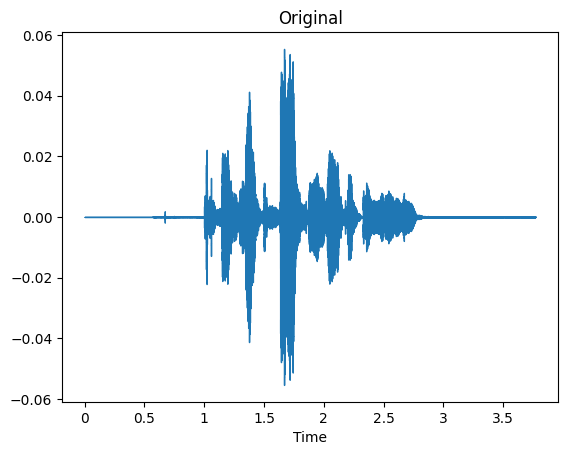

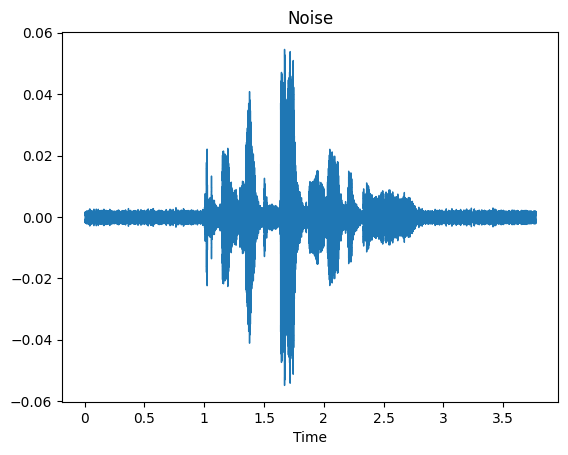

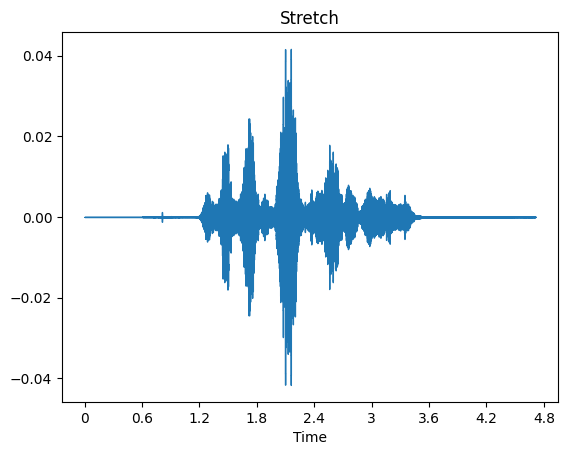

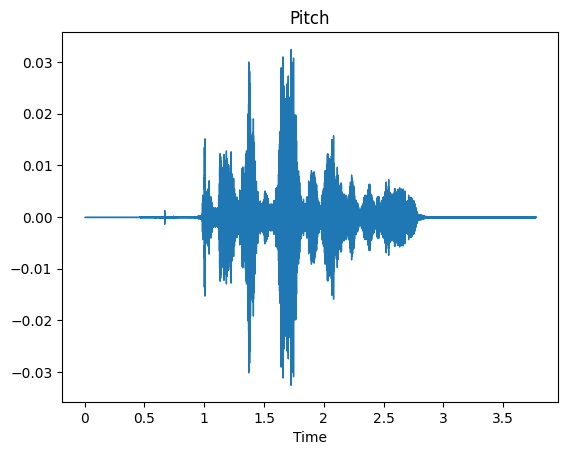

In [25]:
def noise(data):
    return data + 0.035*np.random.uniform()*np.max(data)*np.random.normal(size=data.shape[0])

def stretch(data):
    return librosa.effects.time_stretch(data, rate=0.8)

def pitch(data, sr):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=0.7)

path = data_path.Path.iloc[0]
data, sr = librosa.load(path)

for aug_name, aug_func in [("Original",lambda x:x),
                           ("Noise",noise),
                           ("Stretch",stretch),
                           ("Pitch",lambda x:pitch(x,sr))]:

    aug_data = aug_func(data)
    librosa.display.waveshow(aug_data, sr=sr)
    plt.title(aug_name)
    plt.show()
    display(Audio(aug_data, rate=sr))

In [26]:
def extract_features(data, sr):
    result = np.array([])

    # Zero Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))

    # STFT
    stft = np.abs(librosa.stft(y=data))

    # Chroma
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
    result = np.hstack((result, chroma))

    # MFCC (40 for better accuracy)
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfcc))

    # RMS
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # MelSpectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128).T, axis=0)
    result = np.hstack((result, mel))

    return result

In [27]:
X, Y = [], []

for path, emotion in zip(data_path.Path, data_path.Emotions):
    data, sr = librosa.load(path, duration=2.5, offset=0.6)

    # Original
    X.append(extract_features(data, sr))
    Y.append(emotion)

    # Noise
    noise_data = noise(data)
    X.append(extract_features(noise_data, sr))
    Y.append(emotion)

    # Stretch + Pitch
    stretch_data = stretch(data)
    pitch_data = pitch(stretch_data, sr)
    X.append(extract_features(pitch_data, sr))
    Y.append(emotion)

X = np.array(X)
Y = np.array(Y)

print("Total samples after augmentation:", X.shape)

/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Total samples after augmentation: (36486, 182)


In [28]:
encoder = OneHotEncoder(sparse_output=False)
Y = encoder.fit_transform(Y.reshape(-1,1))

x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=42, shuffle=True
)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

print(x_train.shape)

(27364, 182, 1)


In [29]:
y_integers = np.argmax(y_train, axis=1)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)

class_weights = dict(enumerate(class_weights))

In [30]:
model = tf.keras.Sequential([

    tf.keras.layers.Conv1D(256, 5, padding='same', activation='relu',
                           input_shape=(x_train.shape[1],1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(5, strides=2, padding='same'),

    tf.keras.layers.Conv1D(256, 5, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(5, strides=2, padding='same'),

    tf.keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(3, strides=2, padding='same'),

    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(8, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 182, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 182, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 91, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 91, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 91, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 46, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 46, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 46, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2944)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       753,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,219,336 (4.65 MB)

 Trainable params: 1,217,544 (4.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [32]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-6
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/100
428/428 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.3103 - loss: 1.8122 - val_accuracy: 0.3544 - val_loss: 1.6546 - learning_rate: 5.0000e-04
Epoch 2/100
428/428 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.4486 - loss: 1.2961 - val_accuracy: 0.5184 - val_loss: 1.2838 - learning_rate: 5.0000e-04
Epoch 3/100
428/428 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4965 - loss: 1.1540 - val_accuracy: 0.5128 - val_loss: 1.2628 - learning_rate: 5.0000e-04
Epoch 4/100
428/428 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5206 - loss: 1.0939 - val_accuracy: 0.5166 - val_loss: 1.2536 - learning_rate: 5.0000e-04
Epoch 5/100
428/428 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5236 - loss: 1.0736 - val_accuracy: 0.5453 - val_loss: 1.1549 - learning_rate: 5.0000e-04
Epoch 6/100
428/428 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5387 - loss: 1.0370 - val_accuracy: 0.5300 - val_loss: 1.1803 - learning_rate: 5.0000e-04
Epoch 7/100
428/428 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/st

In [33]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Accuracy:", test_acc * 100)

286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6738 - loss: 0.8427
Test Accuracy: 66.94803833961487


286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


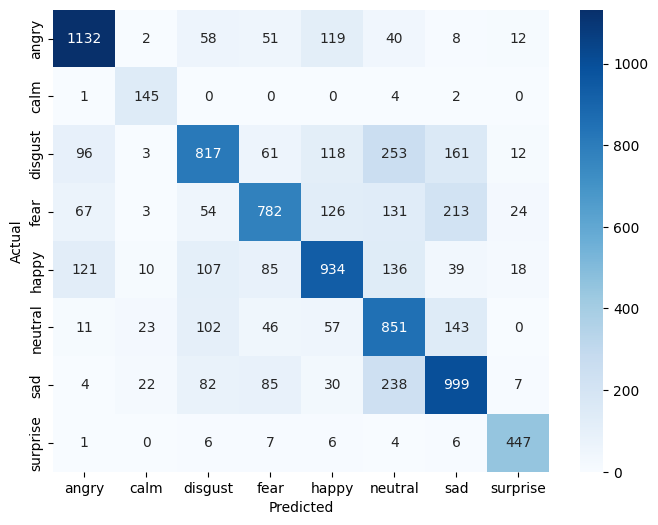

              precision    recall  f1-score   support

       angry       0.79      0.80      0.79      1422
        calm       0.70      0.95      0.81       152
     disgust       0.67      0.54      0.59      1521
        fear       0.70      0.56      0.62      1400
       happy       0.67      0.64      0.66      1450
     neutral       0.51      0.69      0.59      1233
         sad       0.64      0.68      0.66      1467
    surprise       0.86      0.94      0.90       477

    accuracy                           0.67      9122
   macro avg       0.69      0.72      0.70      9122
weighted avg       0.68      0.67      0.67      9122



In [34]:
pred = model.predict(x_test)

y_pred = encoder.inverse_transform(pred)
y_true = encoder.inverse_transform(y_test)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=encoder.categories_[0],
            yticklabels=encoder.categories_[0],
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_true, y_pred))

In [35]:
model.save("ser_model.keras")

import joblib

joblib.dump(scaler, "scaler.pkl")
joblib.dump(encoder, "encoder.pkl")

from google.colab import files

files.download("ser_model.keras")
files.download("scaler.pkl")
files.download("encoder.pkl")




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>